In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [3]:
df=pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.shape

(8807, 12)

In [5]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

In [8]:
df['type'].value_counts()

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

In [9]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  

df.drop(columns=['show_id', 'title', 'director', 'cast', 'description'], inplace=True)


In [10]:
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df['listed_in'] = le.fit_transform(df['listed_in'])


In [12]:

def split_duration(x):
    if pd.isnull(x):
        return pd.Series([np.nan, np.nan])
    x = str(x)
    if 'min' in x:
        return pd.Series([int(x.replace('min', '').strip()), 0])  # movie
    elif 'Season' in x:
        seasons = int(x.split()[0])
        return pd.Series([0, seasons])  # TV Show
    else:
        return pd.Series([np.nan, np.nan])

df[['duration_min', 'num_seasons']] = df['duration'].apply(split_duration)


df.head()


,type,country,date_added,release_year,rating,duration,listed_in,duration_min,num_seasons
0,0,603,"September 25, 2021",2020,PG-13,90 min,265,90,0
1,1,426,"September 24, 2021",2021,TV-MA,2 Seasons,400,0,2
4,1,251,"September 24, 2021",2021,TV-MA,2 Seasons,379,0,2
7,0,663,"September 24, 2021",1993,TV-MA,125 min,307,125,0
8,1,506,"September 24, 2021",2021,TV-14,9 Seasons,110,0,9


In [13]:
df.drop(columns=['duration'], inplace=True)
df.dropna(subset=['date_added', 'rating'], inplace=True)


In [14]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce')
df['date_added'] = df['date_added'].dt.year

In [15]:
df.rating.unique()

array(['PG-13', 'TV-MA', 'TV-14', 'TV-Y7', 'PG', 'R', 'TV-PG', 'TV-Y',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [16]:
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

C:\Users\manos\AppData\Local\Temp\ipykernel_13232\258662981.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].replace(rating_map, inplace = True)


array(['Teens', 'Adults', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

<Axes: xlabel='rating', ylabel='count'>

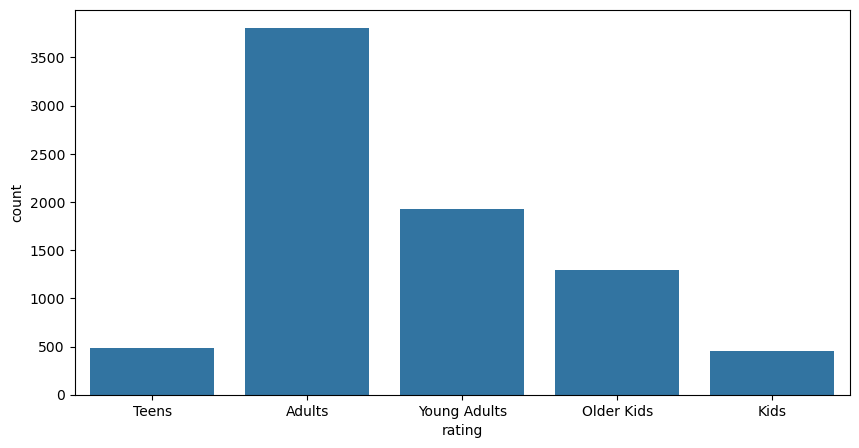

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['rating_encoded'] = le.fit_transform(df['rating'])

print(dict(zip(le.classes_, le.transform(le.classes_))))
print(df[['rating', 'rating_encoded']])
df.drop(columns='rating',inplace=True)

{'Adults': np.int64(0), 'Kids': np.int64(1), 'Older Kids': np.int64(2), 'Teens': np.int64(3), 'Young Adults': np.int64(4)}
            rating  rating_encoded
0            Teens               3
1           Adults               0
4           Adults               0
7           Adults               0
8     Young Adults               4
...            ...             ...
8801        Adults               0
8802        Adults               0
8804        Adults               0
8805    Older Kids               2
8806  Young Adults               4

[7964 rows x 2 columns]


In [19]:
df.columns

Index(['type', 'country', 'date_added', 'release_year', 'listed_in',
       'duration_min', 'num_seasons', 'rating_encoded'],
      dtype='object')

In [20]:
df.isnull().sum()

type              0
country           0
date_added        0
release_year      0
listed_in         0
duration_min      0
num_seasons       0
rating_encoded    0
dtype: int64

In [21]:
df.head()

,type,country,date_added,release_year,listed_in,duration_min,num_seasons,rating_encoded
0,0,603,2021,2020,265,90,0,3
1,1,426,2021,2021,400,0,2,0
4,1,251,2021,2021,379,0,2,0
7,0,663,2021,1993,307,125,0,0
8,1,506,2021,2021,110,0,9,4


In [22]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)


Index(['type', 'country', 'release_year', 'listed_in', 'duration_min',
       'num_seasons', 'rating_encoded'],
      dtype='object')


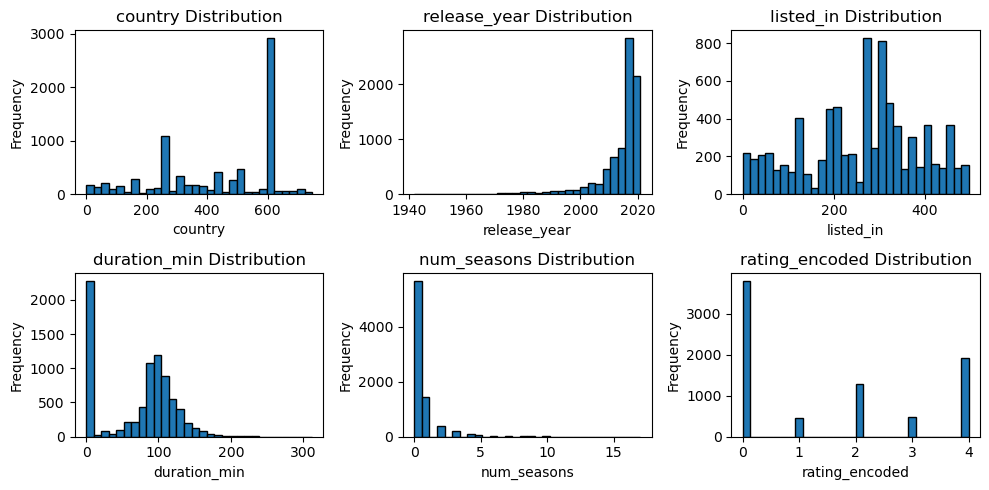

In [23]:
import matplotlib.pyplot as plt

cols = ['country', 'release_year', 'listed_in', 'duration_min',
       'num_seasons', 'rating_encoded']

plt.figure(figsize=(10, 5))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [24]:
df[cols].skew()

country          -0.541727
release_year     -3.335858
listed_in        -0.288673
duration_min     -0.310284
num_seasons       4.283832
rating_encoded    0.458957
dtype: float64

In [25]:
df['num_seasons'] = np.log1p(df['num_seasons'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['release_year'] = scaler.fit_transform(df[['release_year']])


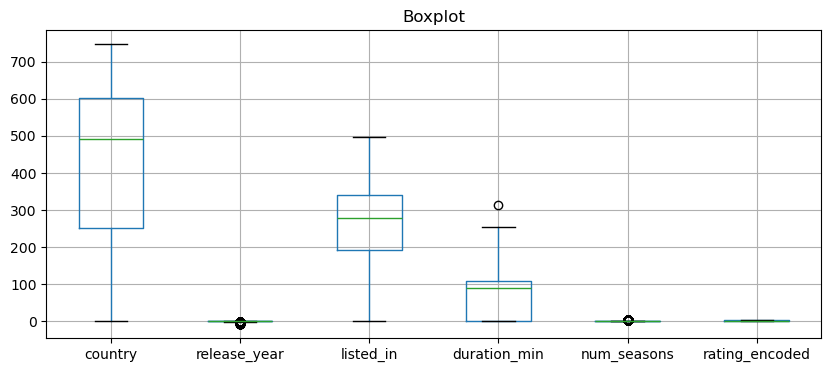

In [26]:
plt.figure(figsize=(10, 4))
df[cols].boxplot()
plt.title("Boxplot")
plt.show()


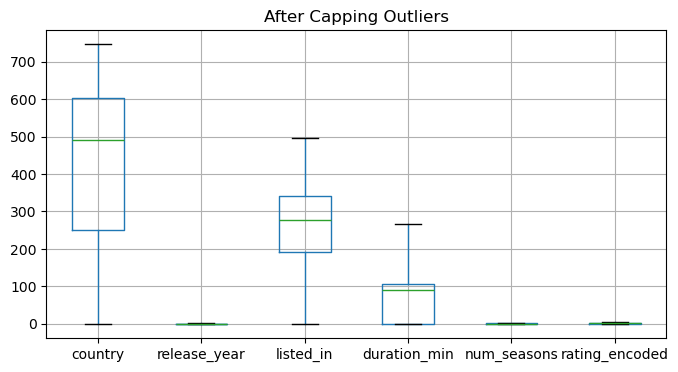

In [27]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Cap the values
    df[col] = np.where(df[col] < lower_limit, lower_limit,
                       np.where(df[col] > upper_limit, upper_limit, df[col]))
    return df
cols = ['country', 'release_year', 'listed_in', 'duration_min',
       'num_seasons', 'rating_encoded']

for col in cols:
    df = cap_outliers(df, col)

plt.figure(figsize=(8, 4))
df[cols].boxplot()
plt.title("After Capping Outliers")
plt.show()



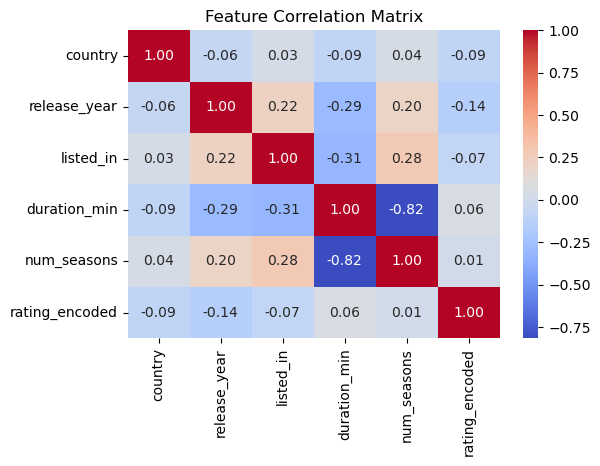

In [28]:
corr = df[['country', 'release_year', 'listed_in', 'duration_min',
       'num_seasons', 'rating_encoded']].corr()
corr
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


In [29]:
X = df.drop(columns=['type'])
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 1.0000
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000
Gradient Boosting Accuracy: 1.0000
Support Vector Machine Accuracy: 0.9843
K-Nearest Neighbors Accuracy: 0.9956


C:\Users\manos\AppData\Local\Temp\ipykernel_13232\840943720.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


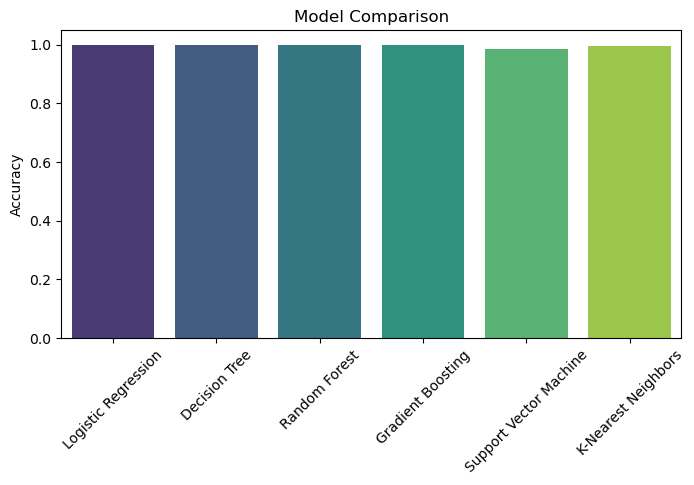

✅ Best Model: Logistic Regression (1.00 accuracy)


In [31]:

plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

best_model_name = max(results, key=results.get)
print(f"✅ Best Model: {best_model_name} ({results[best_model_name]:.2f} accuracy)")


In [32]:

best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Confusion Matrix:
 [[1128    0]
 [   0  465]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1128
           1       1.00      1.00      1.00       465

    accuracy                           1.00      1593
   macro avg       1.00      1.00      1.00      1593
weighted avg       1.00      1.00      1.00      1593



In [33]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    print(f"{name} CV Accuracy: {scores.mean():.4f}")


Logistic Regression CV Accuracy: 0.9997
Decision Tree CV Accuracy: 1.0000
Random Forest CV Accuracy: 1.0000
Gradient Boosting CV Accuracy: 1.0000
Support Vector Machine CV Accuracy: 0.9839
K-Nearest Neighbors CV Accuracy: 0.9944


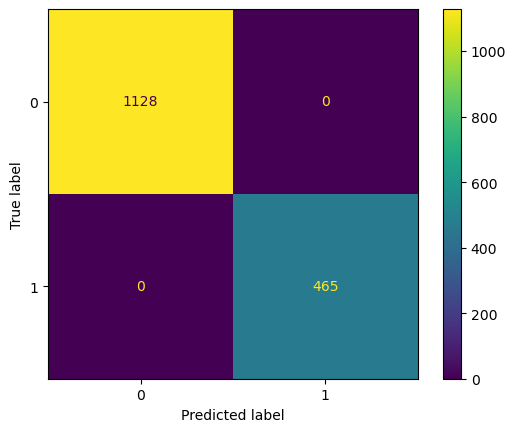

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()


In [35]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best Logistic Regression Accuracy:", grid_lr.best_score_)


# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print("Best Decision Tree Params:", grid_dt.best_params_)
print("Best Decision Tree Accuracy:", grid_dt.best_score_)


# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best Random Forest Params:", grid_rf.best_params_)
print("Best Random Forest Accuracy:", grid_rf.best_score_)


# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)
print("Best Gradient Boosting Params:", grid_gb.best_params_)
print("Best Gradient Boosting Accuracy:", grid_gb.best_score_)


Best Logistic Regression Params: {'C': 1, 'solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.9998430141287283
Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Best Decision Tree Accuracy: 1.0
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 1.0
Best Gradient Boosting Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting Accuracy: 1.0


In [36]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:///C:/Users/manos/mlruns")

mlflow.set_experiment("Netflix_Type_Prediction")


<Experiment: artifact_location='file:///C:/Users/manos/mlruns/959305675312442046', creation_time=1761673667750, experiment_id='959305675312442046', last_update_time=1761673667750, lifecycle_stage='active', name='Netflix_Type_Prediction', tags={}>

In [37]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Decision Tree": grid_dt.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "Gradient Boosting": grid_gb.best_estimator_
}

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_params(model.get_params())
        mlflow.sklearn.log_model(model, name="model_name")


        print(f"{model_name} Accuracy: {acc:.4f}")


2025/10/28 23:28:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Accuracy: 1.0000


2025/10/28 23:28:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree Accuracy: 1.0000


2025/10/28 23:28:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Accuracy: 1.0000


2025/10/28 23:28:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting Accuracy: 1.0000
